# devlog 2024-07-08

_author: Tyler Coles_

A rewrite of the 2023-08-17 devlog to demonstrate initializer system changes.

## Initializer

An `Initializer` is an object that calculates the starting IPM compartments for each population in the geo model. To do this job, epymorph gives it information about the simulation, access to simulation data, and (optionally) additional arbitrary parameters.

There is a small library of initializer implementations built in (see `epymorph.initializer`) or you can write your own implementation for advanced behavior.

As a first example, we'll run some simulations with a single-strata RUME.

In [ ]:
import numpy as np

from epymorph.kit import *

# We'll use the same geographic scope: six southern states (aka, the Pei states).
scope = StateScope.in_states(["FL", "GA", "MD", "NC", "SC", "VA"], year=2020)

# And we will use an SIRS model for our demo. Might as well load it now.
sirs_ipm = ipm.SIRS()

Our RUME has 6 geo nodes; 6 places which we're simulating connected with movement. It's common to initialize an infection in one location and see how it spreads to the others. The `SingleLocation` initializer is perfect for this.

In [2]:
# We create an initializer by constructing it with any parameters it needs.
# SingleLocation has two required parameters:
# - location: the index of the geo node to select for initial infection
# - seed_size: the number of people to initially infect
single_loc_initializer = init.SingleLocation(location=0, seed_size=10_000)

# There are two additional optional parameters:
# - initial_compartment: the index of the IPM compartment which represents
#                        the susceptible population; where do most people start out?
# - infection_compartment: the index of the IPM compartment which represents
#                          the infected/infectious population

# By default they are "0" and "1" respectively; but you can override them if
# those assumptions don't work for the IPM you're using.

# This initializer happens to have the same effect as the one we created above.
# (Because in the SIRS IPM, "S" is index 0 and "I" is index 1.)
single_loc_initializer = init.SingleLocation(
    location=0,
    seed_size=10_000,
    initial_compartment=sirs_ipm.select.compartments("S").compartment_index,
    infection_compartment=sirs_ipm.select.compartments("I").compartment_index,
)

Initializers can have data requirements just like other simulation components. Of course it's useful to be able to inspect these requirements so we can make sure to fill them.

In [3]:
single_loc_initializer.requirements

(AttributeDef(name='population', type=<class 'int'>, shape=Node(), default_value=None, comment='The population at each geo node.'),)

The SingleLocation initializer is programmed to use population data to initialize the simulation. That's handy!

Okay, let's put together the RUME, provide some parameter values, and run our simulation to see it in action.

Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (1.151s)
Loading epymorph.adrio.us_tiger.InternalPoint:
  |####################| 100%  (0.148s)
Loading epymorph.adrio.us_tiger.PostalCode:
  |####################| 100%  (0.088s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.108s


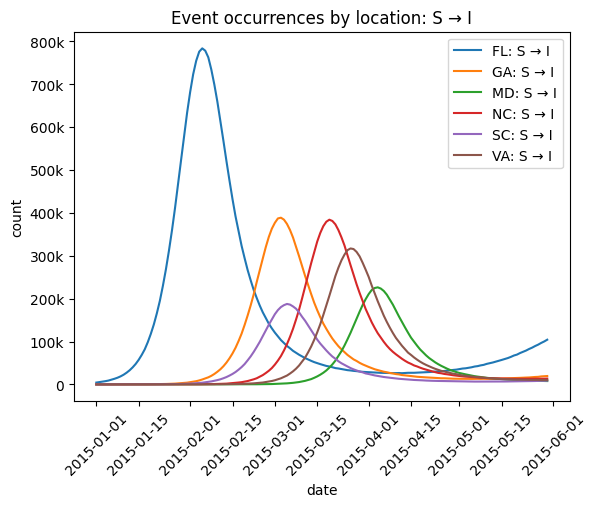

In [4]:
from epymorph.adrio import acs5, us_tiger

rume = SingleStrataRUME.build(
    ipm=sirs_ipm,
    # And we haven't mentioned it so far, but we'll also use
    # the centroids movement model.
    mm=mm.Centroids(),
    init=single_loc_initializer,
    scope=scope,
    time_frame=TimeFrame.of("2015-01-01", duration_days=150),
    params={
        # IPM params
        "beta": 0.4,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        # movement params
        "phi": 60.0,
        "centroid": us_tiger.InternalPoint(),
        # population is needed by both the MM and our initializer
        "population": acs5.Population(),
        # geo labels
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()
    # plot of daily new infections
    out.plot.line(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all(),
        quantity=rume.ipm.select.events("S->I"),
        title="Event occurrences by location: S → I",
    )

## Other initializers

We can also initialize the compartments explicitly, but keep in mind it's up to us to get the numbers right. (Or purposefully "wrong", I suppose!)


In [5]:
# I've chosen these numbers to yield (approximately)
# the same result as the previous run.
explicit_initializer = init.Explicit(
    initials=np.array(
        [
            # S, I, R
            [18_801_310, 10_000, 0],  # FL
            [9_687_653, 0, 0],  # GA
            [5_773_552, 0, 0],  # MD
            [9_535_483, 0, 0],  # NC
            [4_625_364, 0, 0],  # SC
            [8_001_024, 0, 0],  # VA
        ]
    ),
)

# And notice the Explicit initializer doesn't use any other data attribute;
# it doesn't need any!
explicit_initializer.requirements

()

Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (0.483s)
Loading epymorph.adrio.us_tiger.InternalPoint:
  |####################| 100%  (0.084s)
Loading epymorph.adrio.us_tiger.PostalCode:
  |####################| 100%  (0.087s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.108s


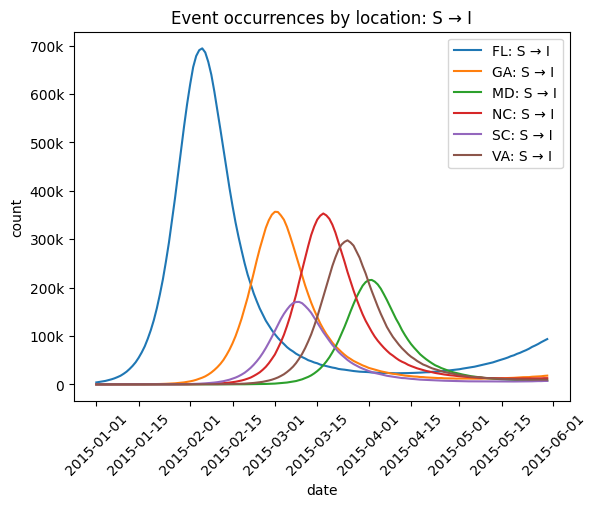

In [6]:
rume = SingleStrataRUME.build(
    ipm=sirs_ipm,
    mm=mm.Centroids(),
    init=explicit_initializer,
    scope=scope,
    time_frame=TimeFrame.of("2015-01-01", duration_days=150),
    params={
        # IPM params
        "beta": 0.4,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        # movement params
        "phi": 60.0,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()
    # plot of daily new infections
    out.plot.line(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all(),
        quantity=rume.ipm.select.events("S->I"),
        title="Event occurrences by location: S → I",
    )

Here's another built-in initializer -- `proportional` -- which will set each population's initial compartments according to the given ratios of their total population. Notice how each initializer takes a unique set of parameters that make sense for their implementation.

Loading epymorph.adrio.acs5.Population:
  |####################| 100%  (0.484s)
Loading epymorph.adrio.us_tiger.InternalPoint:
  |####################| 100%  (0.092s)
Loading epymorph.adrio.us_tiger.PostalCode:
  |####################| 100%  (0.089s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.121s


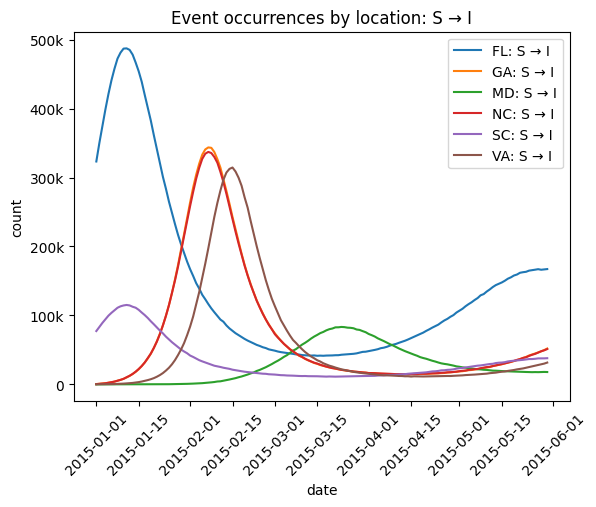

In [7]:
proportional_initializer = init.Proportional(
    # These rows will be normalized, so we are free to express the ratios
    # however we like.
    ratios=np.array(
        [
            # S, I, R
            [75, 5, 20],  # FL
            [0.95, 0, 0.05],  # GA
            [1, 0, 1],  # MD
            [95, 0, 5],  # NC
            [75, 5, 20],  # SC
            [100, 0, 0],  # VA
        ]
    ),
)
# NOTE: Florida and South Carolina start out with a sizable infected population.
# We'll see that in the graph.

rume = SingleStrataRUME.build(
    ipm=sirs_ipm,
    mm=mm.Centroids(),
    init=proportional_initializer,
    scope=scope,
    time_frame=TimeFrame.of("2015-01-01", duration_days=150),
    params={
        # IPM params
        "beta": 0.4,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        # movement params
        "phi": 60.0,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()
    # plot of daily new infections
    out.plot.line(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all(),
        quantity=rume.ipm.select.events("S->I"),
        title="Event occurrences by location: S → I",
    )

Now let's write a custom initializer.

Maybe I want my initialization logic to be influenced by the infection duration ($\frac{1}{\gamma}$) used by the IPM. No problem!

I'll define my initializer class to require `population` and `gamma` attributes, so that I can access these data.

In [8]:
from epymorph.initializer import Initializer

# It's convenient to define these attributes into variables.
POPULATION = AttributeDef("population", int, Shapes.N)
GAMMA = AttributeDef("gamma", float, Shapes.TxN)


# A custom initializer is a class that extends Initializer
# and overrides the `evaluate()` method.
class MyInitializer(Initializer):
    # First we declare the attributes we require.
    requirements = [POPULATION, GAMMA]

    # Now implement `evaluate()`...
    def evaluate(self):
        # This function needs to return an (N,C) array of integers:
        # - N: the number of geo nodes
        # - C: the number of disease compartments
        # Where each value is the number of people in that compartment at that geo node.
        # I'm going to hard-code this to C=3, but we can use `self.dim.compartments`
        # to get the RUME's value of C if we wanted to factor that into our logic.

        # population is an (N,)-shaped array
        pop = self.data(POPULATION)

        # gamma is a (T,N)-shaped array because that's how we defined it;
        # but let's just use the initial values (t=0)
        gamma = self.data(GAMMA)[0, :]  # (N,)

        # This calculation is pretty arbitrary; just for demonstration.
        r = 0.005 * np.log(1 / gamma + 1)  # (N,)
        ratios_sir = np.column_stack([(1 - 2 * r), 0.1 * r, 0.1 * r])  # (N,C)
        ratios_pop = pop[:, np.newaxis] * ratios_sir  # (N,C)
        return ratios_pop.round().astype(SimDType)


# Create a RUME with an instance of the MyInitializer class.
rume = SingleStrataRUME.build(
    ipm=sirs_ipm,
    mm=mm.Centroids(),
    init=MyInitializer(),
    scope=scope,
    time_frame=TimeFrame.of("2015-01-01", duration_days=150),
    params={
        # IPM params
        "beta": 0.4,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        # movement params
        "phi": 60.0,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "meta::geo::label": us_tiger.PostalCode(),
    },
)

# Let's see how the initialization responds to different values of gamma!
# The easiest way to do this is to run the simulations and inspect the
# initial conditions in the output object.
sim = BasicSimulator(rume)
out1 = sim.run({"gamma": 1})
out2 = sim.run({"gamma": 1 / 5})
out3 = sim.run({"gamma": 1 / 8})

# A lower gamma results in more individuals starting in the I and R compartments.
print(f"FL @ t=0, gamma=1  : {out1.initial[0]}")
print(f"FL @ t=0, gamma=1/4: {out2.initial[0]}")
print(f"FL @ t=0, gamma=1/8: {out3.initial[0]}")

FL @ t=0, gamma=1  : [21069859     7353     7353]
FL @ t=0, gamma=1/4: [20836768    19008    19008]
FL @ t=0, gamma=1/8: [20750741    23309    23309]
